# Group project

### Import libraries and data

In [2]:
# Library imports
import time, math, cv2, imutils, os, json, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
# # Task 1 data imports

# # get_data: Import data from file system
# # base_path: Path to the containing folder
# # clip_indexes: Array of clip index values (0-40)
# # Returns array of form [[json, [img1, ...]], [json, [img1, ...]], ...]
# def get_data(base_path, clip_indexes):
#     img_data = []
#     for subdir, dirs, files in os.walk(base_path):
#         # Assumes json is opened first, then all images for it in order
#         for file in files:
#             if (file == "annotation.json"):
#                 with open(os.path.join(subdir, file)) as f:
#                     img_data += [[json.load(f), []]]
#             if (len(file) == 7 and file[-4:] == ".jpg" and int(file[:3]) in clip_indexes):
#                 img_data[-1][1] += [cv2.imread(os.path.join(subdir, file), cv2.IMREAD_GRAYSCALE)]
#     return img_data

# t0 = time.time()

# print("Loading data...")

# # Load data as [annotation, bgr image] pairs
# train_data = get_data("data/train/clips", [40])
# test_data = get_data("data/test/clips", [40])

# print("Done.")
# print("Image load time:", time.time() - t0)

# print("Training clips:", len(train_data))
# print("Testing clips:", len(test_data))

Loading data...
Done.
Image load time: 13.35459280014038
Training clips: 1074
Testing clips: 269


In [4]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all labels
        self.clip_nums = [x for x in os.listdir(self.root) if 'DS_Store' not in x]
        self.img_paths = [Path(root).joinpath(num).joinpath('imgs').joinpath('040.jpg') for num in self.clip_nums]
        self.anno = [Path(root).joinpath(x).joinpath('annotation.json') for x in self.clip_nums]

    def __getitem__(self, idx):
        # load images and masks
        anno_pth = self.anno[idx]
        with open(anno_pth) as f:
          anno_data = json.load(f)
        
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        mask = np.zeros(np.array(img).shape[0:2])
        boxes = []        
        position = []   
        velocity = []
        all_boxes = []
        for car in anno_data:
            left = int(car['bbox']['left'])
            right = int(car['bbox']['right'])
            top = int(car['bbox']['top'])
            bottom = int(car['bbox']['bottom'])
            start_point = (left, top)
            end_point = (right, bottom)  
            color =  1
            thickness = -1
            # Add bounding box
            mask = cv2.rectangle(mask, start_point, end_point, color, thickness)
            if ('position' in car.keys()):
                position += [car['position']]
            if ('velocity' in car.keys()):
                velocity += [car['velocity']]
            all_boxes += [[left, top, right, bottom]]

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target["boxes"] = boxes
        target["allboxes"] = all_boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["position"] = position
        target["velocity"] = velocity

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
TEST_DIR = Path.cwd().parent.joinpath('COMP9517_group_project/data/train/clips')
dataset_test = CarDataset(TEST_DIR, get_transform(train=False))

## Task 1

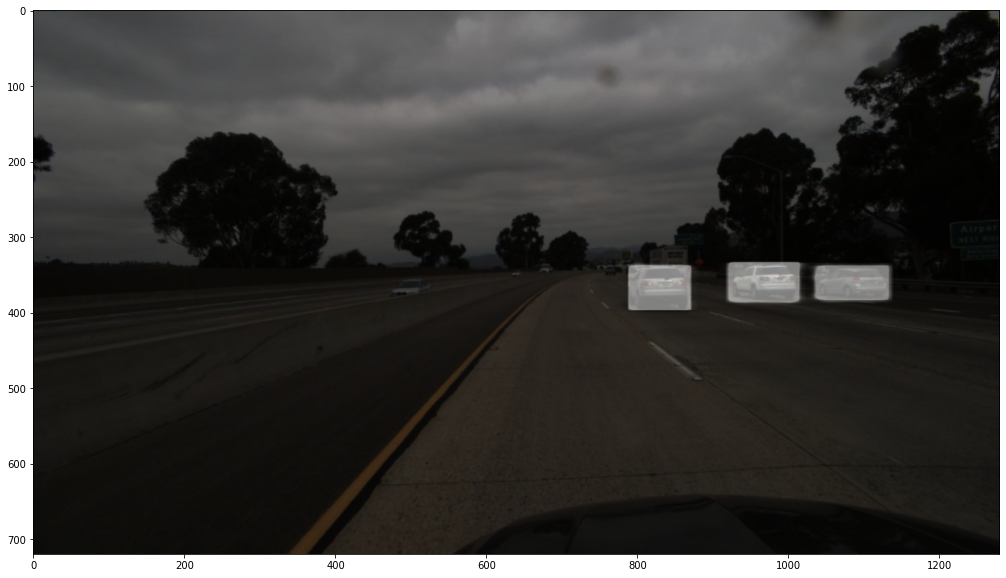

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load('carDetectionModel.pkl')

idx = 0
# pick one image from the test set
img, _ = dataset_test[idx]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

plt.figure(figsize=(20,10))
plt.imshow(image)
mask = np.zeros(img.shape[1:])

for n in range(len(prediction[0]['masks'])):
    mask += prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy()


mask = Image.fromarray(mask)
plt.imshow(mask, cmap='jet', alpha=0.50)
plt.show()

In [8]:
# Code based on stack overflow answer (shorturl.at/koNPR)
# Return intersection over union of the two bounding boxes
def get_iou(b1, b2):
    # 2 -> 0
    # 0 -> 1
    # 3 -> 2
    # 1 -> 3
    x_left = max(b1[0], b2[0])
    y_top = max(b1[1], b2[1])
    x_right = min(b1[2], b2[2])
    y_bottom = min(b1[3], b2[3])

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    b1_area = (b1[2] - b1[0]) * (b1[3] - b1[1])
    b2_area = (b2[2] - b2[0]) * (b2[3] - b2[1])

    div = float(b1_area + b2_area - intersection_area)
    if div == 0: div = .001
    iou = intersection_area / div

    return iou

In [32]:
# Generate bounding boxes
iou_threshhold = .5
bounding_ratio  = 2.0
def gen_boxes(inp, show=False):
    img, target = inp
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    tmp_boxes = []
    for n in range(len(prediction[0]['boxes'])):
        tmp = prediction[0]['boxes'][n].cpu().detach().numpy().astype(int)
        tmp_boxes += [tmp]
    
    boxes = []
    for box1 in tmp_boxes:
        if (abs(box1[0] - box1[2]) / abs(box1[1] - box1[3]) > bounding_ratio):
            continue
        overlap = False
        for box2 in boxes:
            if get_iou(box1, box2) > iou_threshhold:
                overlap = True
        if not overlap: boxes += [box1]
    
    if (show):
        img2 = np.copy(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))
        img3 = np.copy(img2)
        for box in boxes:
            cv2.rectangle(img2,(box[0],box[1]),(box[2],box[3]),(150,255,255),2)

        for box in target['allboxes']:
            #box = box.cpu().detach().numpy().astype(int)
            cv2.rectangle(img3,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)

        fig, axs = plt.subplots(1, 2, figsize=(20, 12))
        axs[0].imshow(img2)
        axs[0].set_title('prediction')
        axs[0].set_axis_off()
        axs[1].imshow(img3)
        axs[1].set_title('Ground truth')
        axs[1].set_axis_off()
        plt.show()

    return boxes

In [13]:
# avg_car_width = 1.80 # meters
# avg_car_height = 1.58 # meters
# camera_height = 1.80 # meters
fx = 414.1526 # px
fy = 710.3725 # px
cx = 713.85   # px
cy = 327.0    # px
# rescale = 2.2
# truck_ratio = 0.92
# for k in range(10):
#     truck_ratio = 0.9 + k*.01
#     percent_diff = []
#     for i in range(len(dataset_test)):
#         img, t = dataset_test[i]
#         shp = img.shape

#         boxes = t["allboxes"]
#         positions = t["position"]

#         for j in range(len(boxes)):
#             box = boxes[j]
#             pos = positions[j]
#             c_w = (box[2] - box[0])
#             c_h = (box[3] - box[1])
#     #         print(c_h, c_w)
#     #         # print(fx * avg_car_width / c_w)
#     #         print(fy * avg_car_height / c_h)
#             # print((avg_car_height+avg_car_width) / (c_h+c_w), avg_car_height/c_h)
            
#             if (c_h <= c_w * truck_ratio): # height is more reliable, unless it's a tall vehicle 
#                 dist_estim = fy * avg_car_height / c_h
#             else:
#                 dist_estim = rescale * fx * avg_car_width / c_w
#             dist = math.sqrt(pos[0]*pos[0] + pos[1]*pos[1] + camera_height*camera_height/4)
#             diff = abs(dist_estim - dist)
#             # print(dist_estim, dist)
#     #         print(dist, "meters")
#             percent_diff += [diff / dist]
#     #         print()
#     print(round(truck_ratio, 2), round(sum(percent_diff)/len(percent_diff), 4))

In [ ]:
avg_car_width = 1.80 # meters
avg_car_height = 1.58 # meters
camera_height = 1.80 # meters
rescale = 2.2
truck_ratio = 0.92
img, t = dataset_test[0]
_, h, w = img.shape
percent_diff = []
res = []
out = np.zeros((h, w, 3)).astype(int)
bad = []
for i in range(len(dataset_test)):
    img, t = dataset_test[i]
    boxes = t["allboxes"]
    positions = t["position"]
    
    for j in range(len(boxes)):
        box = boxes[j]
        pos = positions[j]
        c_w = (box[2] - box[0])
        c_h = (box[3] - box[1])
        
        if (c_h <= c_w * truck_ratio): # height is more reliable, unless it's a tall vehicle 
            dist_estim = fy * avg_car_height / c_h
        else:
            dist_estim = rescale * fx * avg_car_width / c_w
        dist = math.sqrt(pos[0]*pos[0] + pos[1]*pos[1]) # + camera_height*camera_height/4)
        diff = abs(dist_estim - dist) # abs(dist_estim - dist)
        
        dist_from_c = w / 2 - (box[2] + box[0]) / 2
        percent_diff += [[(dist_estim - dist) / dist, c_h, dist_from_c, diff]]
        res += [[dist_estim, dist_from_c, pos, c_h, c_w]]
        
        tmp = np.zeros((h, w, 3)).astype(int)
        
        if (diff / dist < .3): continue
        bad += [i]
        weight = math.sqrt(diff / dist) * 1.3
        cv2.rectangle(tmp,(box[0],box[1]),(box[2],box[3]),(255*weight, 255*(1.0-weight), 0),2)
        out = cv2.addWeighted(out, 1.0, tmp, 0.15, 0)
print(len(bad))
fig, axs = plt.subplots(1, 1, figsize=(20, 12))
axs.imshow(out)
axs.set_title('boxes')
axs.set_axis_off()
plt.show()
# print(sum(percent_diff)/len(percent_diff))

In [ ]:
# print(bad)
for i in bad: gen_boxes(dataset_test[i], True)

Avg percent difference: -0.011255531457805876
Avg difference: 3.3512251933431543
39.800970873786405
-0.006823643879503559 515
-0.0028993141471202063 504
-0.02495711564515019 177
-0.036969019717570085 157


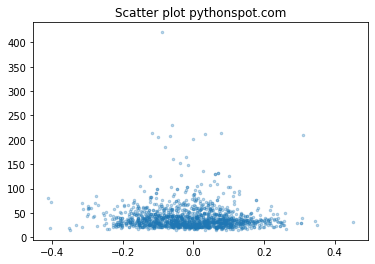

<Figure size 1440x720 with 0 Axes>

In [20]:
print("Avg percent difference:", sum([i[0] for i in percent_diff])/len(percent_diff))
print("Avg difference:", sum([i[3] for i in percent_diff])/len(percent_diff))
print(sum([i[1] for i in percent_diff])/len(percent_diff))
lall0 = [i[0] for i in percent_diff]
lall1 = [i[1] for i in percent_diff]
lall2 = [i[2] for i in percent_diff]
l0 = [i[0] for i in percent_diff if i[1] < 30]
l1 = [i[0] for i in percent_diff if i[1] > 30 and i[1] < 45]
l2 = [i[0] for i in percent_diff if i[1] > 45 and i[1] < 60]
l3 = [i[0] for i in percent_diff if i[1] > 60]
print(sum(l0)/len(l0), len(l0))
print(sum(l1)/len(l1), len(l1))
print(sum(l2)/len(l2), len(l2))
print(sum(l3)/len(l3), len(l3))

area = np.pi*2
plt.scatter(lall0, lall1, s=area, alpha=0.3)
plt.title('Scatter plot pythonspot.com')
plt.figure(figsize=(20,10))
plt.show()

Percent error:      9.9863 %
Average distance:   3.539 meters
Average y distance: 0.731 meters
Average x distance: 3.333 meters


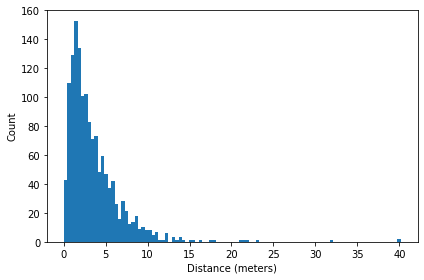

In [31]:
# split in x-z coordinates
per_err = []
y_offset = -2.2 # Since camera isn't centered
dist_offset = 0.3
# for t in range(0, 20):
#     default = t*.1
for v in res:
    dist_estim = v[0]
    x0         = v[1]
    pos        = v[2]
    c_h        = v[3]

    Y0 = -x0 * avg_car_height / c_h + y_offset

    if (dist_estim < abs(Y0)):
        X0 = 0
    else:
        X0 = math.sqrt((dist_estim+dist_offset)*(dist_estim+dist_offset) - Y0*Y0 - camera_height*camera_height/4)
# z -> x
# x -> y

#     print(round(X0,2), round(Z0,2))
#     print(round(pos[1],2), round(pos[0],2))
#     print()

    dist = math.sqrt(pos[0]*pos[0] + pos[1]*pos[1] + camera_height*camera_height/4)

    dist_from_real = math.sqrt((Y0 - pos[1])*(Y0 - pos[1]) + (X0 - pos[0])*(X0 - pos[0]))
    x_dist = abs(X0 - pos[0])
    y_dist = abs(Y0 - pos[1])
    per_err += [[dist_from_real/dist, dist_from_real, y_dist, x_dist]]

print("Percent error:     ",  round(sum([i[0] for i in per_err])/len(per_err) * 100,4), "%")
print("Average distance:  ", round(sum([i[1] for i in per_err])/len(per_err),3), "meters")
print("Average y distance:", round(sum([i[2] for i in per_err])/len(per_err),3), "meters")
print("Average x distance:", round(sum([i[3] for i in per_err])/len(per_err),3), "meters")

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)

ax.hist([i[1] for i in per_err], bins=100)
ax.set_xlabel('Distance (meters)')
ax.set_ylabel('Count')
plt.show()

In [ ]:
# # split in x-z coordinates

# x_offset = -2.2
# dist_offset = 0.3
# # for t in range(0, 20):
# #     default = t*.1
# for l in range(30):
#     x_offset = 0.0 - l*.1
#     per_err = []
#     for v in res:
#         dist_estim = v[0]
#         x0         = v[1]
#         pos        = v[2]
#         c_h        = v[3]
        
#         X0 = -x0 * avg_car_height / c_h + x_offset

#         if (dist_estim < abs(X0)):
#             Z0 = 0
#         else:
#             Z0 = math.sqrt((dist_estim+dist_offset)*(dist_estim+dist_offset) - X0*X0 - camera_height*camera_height/4)



#     #     print(round(X0,2), round(Z0,2))
#     #     print(round(pos[1],2), round(pos[0],2))
#     #     print()

#         dist = math.sqrt(pos[0]*pos[0] + pos[1]*pos[1])

#         dist_from_real = math.sqrt((X0 - pos[1])*(X0 - pos[1]) + (Z0 - pos[0])*(Z0 - pos[0]))
#         per_err += [[dist_from_real/dist, dist_from_real]]

#     print("\n", x_offset)
#     print("Percent error:", sum([i[0] for i in per_err])/len(per_err))
#     print("Average distance:", sum([i[1] for i in per_err])/len(per_err))